# Estrategia 04
---

En esta estrategia se buscó explorar el uso de redes neuronales para este tipo de clasificación. La hipótesis antes del desarrollo es que este tipo de clasificador será capaz de alcanzar la mayor ```accuracy``` particular para este problema.

---
## 1) Carga de Datos

In [120]:
import numpy as np
import os

# data directory path
DATADIR = 'data'

# carga de datos de training
x_training = np.load(os.path.join(DATADIR, 'training', 'dataset_features.npy'), allow_pickle=True)
label_training = np.load(os.path.join(DATADIR, 'training', 'dataset_labels.npy'), allow_pickle=True)
d_train = np.array([int(y[1:3]) for y in label_training])

# carga de datos de testing
x_testing = np.load(os.path.join(DATADIR, 'testing', 'dataset_features.npy'), allow_pickle=True)
label_testing = np.load(os.path.join(DATADIR, 'testing', 'dataset_labels.npy'), allow_pickle=True)
d_test = np.array([int(y[1:3]) for y in label_testing])

# features_label
flabels = np.load(os.path.join(DATADIR, 'flabels.npy'), allow_pickle=True)

### - Uso de caracteristicas:

Para esta estrategia se buscó utilizar las features **geométricas** y de **intensidad** que han mostrado ser las mejores características para estas clasificaciones.

In [143]:
#to_use = ['hu', 'flusser', 'int']
to_use = ['gabor', 'flusser', 'har']

use_columns = []
for label in flabels:  # nombre de la feature
    for ftype in to_use:  # nombres de las features que queremos usar
        if ftype in label:
            use_columns.append(*np.where(flabels == label)[0])  # agregamos el indice de la feature

print(f'Using only {len(use_columns)} features...')

# selecionamos solo esas columnas
x_train = x_training[:, use_columns]
x_test = x_testing[:, use_columns]

Using only 99 features...


## 2) Transformación y Selección de Características

- En esta estrategia se van a utilizar los siguientes procesos de transformación y selección de caracterísiticas:

    1. Cleaning.
    2. Normalization (```mean```).
    3. Selection (```sbs``` para ```37``` características).


### - Training:

In [144]:
from modules.feature_selection import sequential_backward_selection as sbs
from sklearn.preprocessing import StandardScaler
from pybalu.feature_selection import clean

FEATURES = 37

# Training: Cleaning
sclean = clean(x_train, show=False)
x_train_clean = x_train[:, sclean]
print('After Cleaning   : ' + str(x_train_clean.shape[1]) + ' features.')

# Training: Normalization
scaler = StandardScaler()
scaler.fit(x_train_clean)
x_train_norm = scaler.transform(x_train_clean)
print('Normalized       : ' + str(x_train_norm.shape[1]) + ' features.')

# Training: Feature selection
selected = sbs(x_train_norm, d_train, n_features=FEATURES, method="fisher")
x_train_selected = x_train_norm[:, selected]
print('After Selection  : ' + str(x_train_selected.shape[1]) + ' features.')

After Cleaning   : 63 features.
Normalized       : 63 features.
After Selection  : 37 features.


### - Testing:

In [145]:
# Testing: Cleaning
x_test_clean = x_test[:, sclean]

# Testing: Normalization
x_test_norm = scaler.transform(x_test_clean)

# Testing: Feature selection
x_test_selected = x_test_norm[:, selected]

print('Testing ft: '+ str(x_test_selected.shape[1]) + ' from (' + str(x_test_selected.shape[0]) + ' samples)')

Testing ft: 37 from (1260 samples)


## 3) Classification:

Finalmente, se utilizó como clasificador una *Red Neuronal*.

### - Clasificador individual:

Accuracy:  0.959


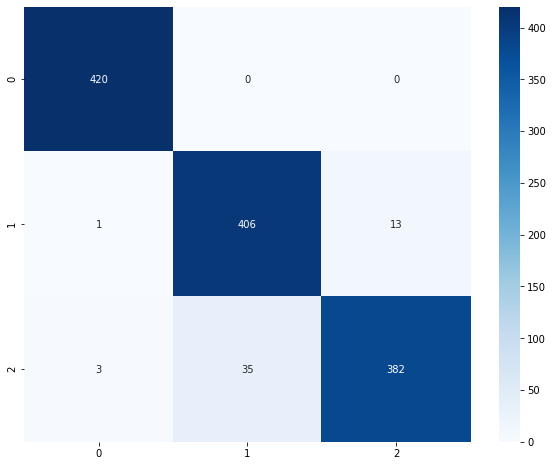

In [156]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SOLVER = 'adam'  # sgd, lbfgs
ALPHA = 0.0001   # float 
HLAYERS = (170, 75)
MAX_ITER = 2000

# Classification on Testing dataset
net = MLPClassifier(solver=SOLVER, alpha=ALPHA, hidden_layer_sizes=HLAYERS, max_iter=MAX_ITER,
                   warm_start=False)
net.fit(x_train_selected, d_train)

predicted = net.predict(x_test_selected)

acc = accuracy_score(d_test, predicted)
print('Accuracy: ', round(acc, 3))

cmatrix = confusion_matrix(d_test, predicted)


fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmatrix, cmap="Blues", annot=True, ax=ax, fmt='g')

### - Clasificador Grupal:
- Ahora vamos a medir la *accuracy* para la clasificación según lo predicho en la etapa anterior. Esto se hace con un sistema de votación por cada *patch*.

In [157]:
# contadores por clase y tipo de votos
votes = {'00': {}, '01': {}, '02': {}}
for i in range(label_testing.shape[0]):
    label = label_testing[i]
    # si aún no se agrega esta clase
    if not label[4:8] in votes[label[1:3]].keys():
        votes[label[1:3]][label[4:8]] = [predicted[i]]
    else:
        votes[label[1:3]][label[4:8]].append(predicted[i])

In [158]:
# hacemos la clasificación en grupos vamos a contruir un predict and true value
group_predicted = []
group_true_value = []
for cnumber in votes:
    for gnumber in votes[cnumber]:
        group_true_value.append(int(cnumber))
        predicted_list = votes[cnumber][gnumber]
        group_predicted.append(max(set(predicted_list), key=predicted_list.count))
g_predicted = np.array(group_predicted)
g_test = np.array(group_true_value)

Accuracy:  0.976


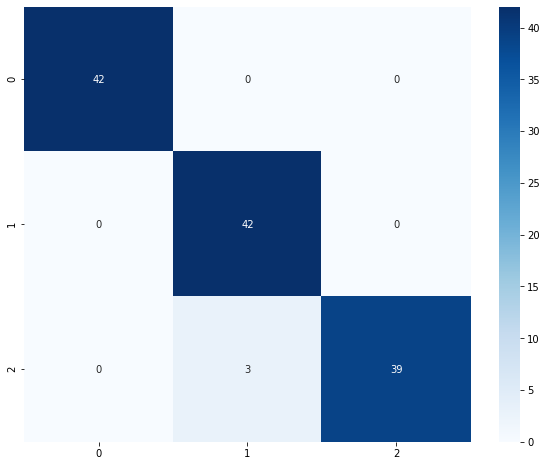

In [159]:
# estadisticas por grupos
g_acc = accuracy_score(g_test, g_predicted)
print('Accuracy: ', round(g_acc, 3))

g_cmatrix = confusion_matrix(g_test, g_predicted)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(g_cmatrix, cmap="Blues", annot=True, ax=ax, fmt='g')